In [ ]:
import pandas as pd
import cv2
from cv2 import imread, resize # manipulating the images
import numpy as np
from keras.models import Sequential, load_model


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, \
     Dense, Input, Activation, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from cv2 import imread, resize # manipulating the images
from tensorflow.keras.optimizers import Adam
import os

In [11]:
groundTruth = pd.read_csv("../../data/archive/HAM10000_metadata.csv").head(n=5000)
groundTruth

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
4995,HAM_0007146,ISIC_0031493,nv,follow_up,60.0,female,back
4996,HAM_0004659,ISIC_0027993,nv,follow_up,60.0,female,abdomen
4997,HAM_0000399,ISIC_0027599,nv,follow_up,60.0,female,upper extremity
4998,HAM_0001291,ISIC_0024613,nv,follow_up,60.0,female,upper extremity


In [12]:
groundTruth.groupby('dx')['image_id'].agg(['count'])

,count
dx,
bcc,514
bkl,1095
df,115
mel,1109
nv,2025
vasc,142


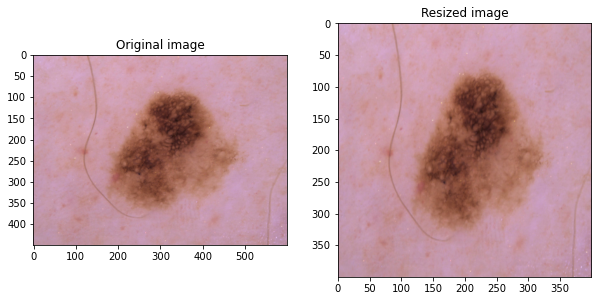

In [13]:
file_to_read ='../../data/archive/HAM10000_images_part_1/ISIC_0025665.jpg'

img = cv2.imread(file_to_read)
img2 = cv2.resize(img, (400, 400))

# Show one exampe image before and after
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, ::-1])
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(img2[:, :, ::-1])
plt.title('Resized image')
plt.show()

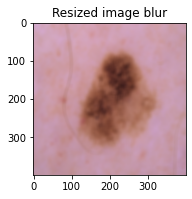

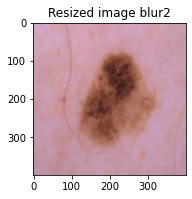

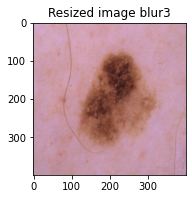

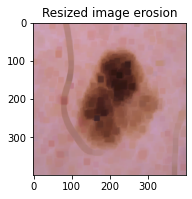

In [14]:
new_img_r1 = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)
new_img_r2 = cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)
new_img_r3 = cv2.rotate(img2, cv2.ROTATE_180)
new_img_i1 = cv2.flip(img2, 0)
new_img_i2 = cv2.flip(img2, 1)
ksize = (10, 10)
new_img_blur = cv2.blur(img2,ksize)
ksize = (5, 5)
new_img_blur2 = cv2.blur(img2,ksize)
ksize = (1, 1)
new_img_blur3 = cv2.blur(img2,ksize)

kernel=np.ones((5,5),np.uint8)
new_img_er=cv2.erode(img2,kernel,iterations=3)



# plt.subplot(1, 2, 2)
# plt.imshow(new_img_r1[:, :, ::-1])
# plt.title('Resized image rotate 1')
# plt.show()
# plt.subplot(1, 2, 2)
# plt.imshow(new_img_r2[:, :, ::-1])
# plt.title('Resized image rotate 2')
# plt.show()
# plt.subplot(1, 2, 2)
# plt.imshow(new_img_r3[:, :, ::-1])
# plt.title('Resized image rotate 3')
# plt.show()
# plt.subplot(1, 2, 2)
# plt.imshow(new_img_i1[:, :, ::-1])
# plt.title('Resized image invert 1')
# plt.show()
# plt.subplot(1, 2, 2)
# plt.imshow(new_img_i2[:, :, ::-1])
# plt.title('Resized image invert 2')
# plt.show()

plt.subplot(1, 2, 2)
plt.imshow(new_img_blur[:, :, ::-1])
plt.title('Resized image blur')
plt.show()
plt.subplot(1, 2, 2)
plt.imshow(new_img_blur2[:, :, ::-1])
plt.title('Resized image blur2')
plt.show()
plt.subplot(1, 2, 2)
plt.imshow(new_img_blur3[:, :, ::-1])
plt.title('Resized image blur3')
plt.show()

plt.subplot(1, 2, 2)
plt.imshow(new_img_er[:, :, ::-1])
plt.title('Resized image erosion')
plt.show()

In [15]:
def distortImages(orignal_image, image_class):
    """
    takes original image (already re-sized) and distorts several times and returns a list of modified images
    Distorts it more times if the class is less present in the data set.
    """
    #These are the original counts, 
    #If NV just switch orientation once are return 2 images total ~13,000 per class
    #If mel or bkl switch orientation 5 times and 2 blurs 12 images total ~ 10,000 per class
    #If akiec or bcc switch orientation 5 times and do 4 blurs ~ 12,000 images
    #Else switch orientation 5 times and to 10 blurs ~10,00 per class
#     #akiec	327
#     #bcc	514
#     #bkl	1099
#     df	115
#     #mel	1113
#     nv	6705
#     vasc	142

    if image_class == "nv":
        new_img_a = cv2.flip(orignal_image, 0)
#         images_to_return = [new_img_a, orignal_image]
        images_to_return = [ orignal_image]


    else:
        if image_class == "mel" or image_class == "bkl":
#             blurs = [1,10]

            blurs = [1]

        elif image_class == "akiec" or image_class == "bcc":
#             blurs = [1,3,6,10]
            blurs = [1,10]


        elif image_class == "df" or image_class == "vasc":
#             blurs = [1,2,3,4,5,6,7,8,9,10]
            blurs = [1,5,10]

            
        for b in blurs:
            #Rotate images and add blur
            ksize = (b, b)
            new_img_a = cv2.blur(orignal_image, ksize)
            new_img_b = cv2.blur(cv2.rotate(orignal_image, cv2.ROTATE_90_CLOCKWISE), ksize)
#             new_img_c = cv2.blur(cv2.rotate(orignal_image, cv2.ROTATE_90_COUNTERCLOCKWISE), ksize)
#             new_img_d = cv2.blur(cv2.rotate(orignal_image, cv2.ROTATE_180), ksize)
#             new_img_e = cv2.blur(cv2.flip(orignal_image, 0), ksize)
#             new_img_f = cv2.blur(cv2.flip(orignal_image, 1), ksize)

#         images_to_return = [new_img_a, new_img_b, new_img_c, new_img_d, new_img_e, new_img_f] 
#         images_to_return = [new_img_a, new_img_b]   
        images_to_return = [orignal_image]


    return(images_to_return)
            
            

In [16]:
y = []
x = []
i = 0

class_dict = {"akiec": 0,
              "bcc": 0,
              "mel": 0,
              "bkl": 0,
              "df": 0,
              "vasc": 0,
              "nv": 0}
for index, row in groundTruth.iterrows():
    i +=1
    current_class = row['dx']
    current_image_id = row['image_id'] 
    
    file_to_read =f'../../data/archive/HAM10000_images_part_1/{current_image_id}.jpg'

    img = cv2.imread(file_to_read)
    new_img = cv2.resize(img, (400, 400))
    
    all_cur_images = distortImages(new_img, current_class)
    for j in all_cur_images:
        x.append(j)
        y.append(current_class)
        class_dict[current_class] +=1
    

    if i % 500 == 0:
        print(i, 'images loaded')
    


500 images loaded
1000 images loaded
1500 images loaded
2000 images loaded
2500 images loaded
3000 images loaded
3500 images loaded
4000 images loaded
4500 images loaded
5000 images loaded


In [17]:
x_array = np.array(x)
y_array = np.array(y)


y_train = pd.get_dummies(y_array)
y_train = y_train.values.argmax(1)
print(y_train)

X_train, X_test, y_train, y_test = train_test_split(x_array,                  
                                                    y_train,            
                                                    test_size = 0.20,   
                                                    random_state = 50,  
                                                    stratify = y_array)       

print('Train dataset shape', x_array.shape)
print('Test dataset shape', y_array.shape)

[1 1 1 ... 4 4 4]
Train dataset shape (5000, 400, 400, 3)
Test dataset shape (5000,)


In [18]:
model = Sequential()
        

model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="valid"))
model.add(BatchNormalization())


model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(BatchNormalization())


model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten()) 

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))
              

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))
              
model.add(Dense(7, activation = 'softmax'))

2022-12-15 12:57:03.644859: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
def mod_checkpoint_callback() -> None:
    
    trained_model = ModelCheckpoint(filepath = 'model.h5',  
                             save_weights_only = False,     
                             monitor = 'val_accuracy',      
                             mode = 'auto',                 
                             save_best_only = True,     
                             verbose = 1)
    return trained_model

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [21]:
early_stopping_monitor = EarlyStopping(patience = 35, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()


optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

datagen = ImageDataGenerator(zoom_range = 0.3, horizontal_flip = True, shear_range = 0.3)
datagen.fit(X_train)

batch_size = 16
epochs = 2


history = model.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )

NameError: name 'new_class_weights' is not defined